In [1]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils
from modules import helpers, training
from modules.nn import mlp

In [3]:
import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)

importlib.reload(mlp)
# importlib.reload(pca)

<module 'modules.nn.mlp' from '/Users/yongao/Desktop/8.13/mit-jlab-sp25/modules/nn/mlp.py'>

In [4]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [6]:
four_leptons_data = utils.FourLeptonsData()
four_leptons_nn = utils.FourLeptonNN()

In [7]:
print('Higgs:')
mc_higgs_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'higgs2011.csv',
            MC_dir + 'higgs2012.csv'
        ]
    ],
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('ZZ:')
mc_zz_all_data = four_leptons_data.apply_basic_cuts(
    [ 
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'zzto4mu2011.csv',
            MC_dir + 'zzto2mu2e2011.csv',
            MC_dir + 'zzto4e2011.csv',

            MC_dir + 'zzto4mu2012.csv',
            MC_dir + 'zzto2mu2e2012.csv',
            MC_dir + 'zzto4e2012.csv',
        ]
    ],
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('Drell-Yan:')
mc_dy_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'dy1050_2011.csv',
            MC_dir + 'dy50_2011.csv',
            MC_dir + 'dy1050_2012.csv',
            MC_dir + 'dy50_2012.csv'
        ]
    ],
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('tt:')
mc_tt_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'ttbar2011.csv',
            MC_dir + 'ttbar2012.csv'
        ]
    ],
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('data:')
data_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            data_dir + 'clean_data_2011.csv',
            data_dir + 'clean_data_2012.csv'
        ]
    ],
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Conservation cut: 121906 events passed out of 124496 (98%)
 Leptons cut: 96829 events passed out of 121906 (79%)
 Conservation cut: 104065 events passed out of 107496 (97%)
 Leptons cut: 79850 events passed out of 104065 (77%)
Drell-Yan:
 Conservation cut: 29 events passed out of 59 (49%)
 Leptons cut: 1 e

In [8]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = four_leptons_data.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = four_leptons_data.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = four_leptons_data.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

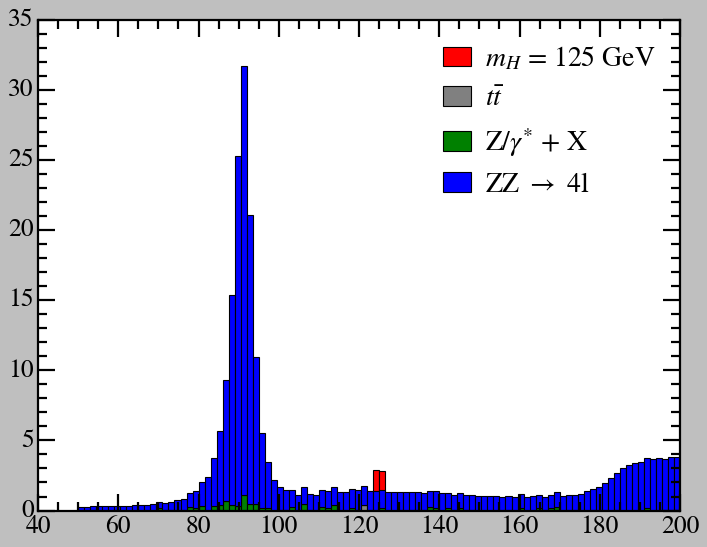

In [9]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [10]:
if False:
    class FourLeptonsPCA(pca.PCA):
        def __init__(self,
                    all_data,data_labels,
                    fields,field_indices):
            self.all_data = all_data
            self.event_nums = [len(data) for data in all_data]
            self.all_labels = [np.array([label]*len(data)) for label,data in zip(data_labels,all_data)]

            self.fields = fields
            self.field_indices = [field_indices[field] for field in fields]

        def _subsample(self, data, label, n):
            idx = np.random.choice(len(data), n, replace=False)
            return data[idx], label[idx]
        
        def get_pca(self):
            X = []
            Y = []

            for data,label in zip(self.all_data,self.all_labels):
                reduced_data, reduced_label = self._subsample(data,label,min(self.event_nums))
                X.append(reduced_data)
                Y.append(reduced_label)

            X = np.concatenate(X)
            Y = np.concatenate(Y)

            X = torch.from_numpy(X)

            X_norm, X_mean, X_std = self._standardize(X)
            X_pca, V = self._perform_pca(X_norm)

            return X_pca.numpy()[Y==1], X_pca.numpy()[Y==0]

In [11]:
if False:
    mc_all_data = mc_higgs_all_data + mc_zz_all_data
    fields = [
        'E1', 'px1', 'py1', 'pz1',
        'E2', 'px2', 'py2', 'pz2',
        'E3', 'px3', 'py3', 'pz3',
        'E4', 'px4', 'py4', 'pz4',
    ]

    mc_all_pca = FourLeptonsPCA(all_data=mc_all_data,
                                data_labels=[1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
                                fields=fields,
                                field_indices=params.field_indices)
    higgs_pca, zz_pca = mc_all_pca.get_pca()

In [12]:
if False:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,0.5)

        plt.tight_layout()
        plt.show()

In [13]:
all_higgs_and_zz_data = [
    four_leptons_data.read_data(file) for file in [
        MC_dir + 'higgs2011.csv',
        MC_dir + 'higgs2012.csv',

        MC_dir + 'zzto4mu2011.csv',
        MC_dir + 'zzto2mu2e2011.csv',
        MC_dir + 'zzto4e2011.csv',
        MC_dir + 'zzto4mu2012.csv',
        MC_dir + 'zzto2mu2e2012.csv',
        MC_dir + 'zzto4e2012.csv',

        MC_dir + 'dy1050_2011.csv',
        MC_dir + 'dy50_2011.csv',
        MC_dir + 'dy1050_2012.csv',
        MC_dir + 'dy50_2012.csv',
    ]
]

all_higgs_and_zz_data = four_leptons_data.apply_basic_cuts(
    all_higgs_and_zz_data,
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=False
)

fields = [
    'px1','py1',
    'px2','py2',
    'px3','py3',
    'px4','py4',
]

X_higgs_and_zz, Y_higgs_and_zz = four_leptons_nn.get_training_data(
    all_data = all_higgs_and_zz_data,
    data_labels = [1]*2 + [0]*10,
    fields = fields,
)
higgs_and_zz_train_loader, higgs_and_zz_val_loader, N_data, N_train, N_val = four_leptons_nn.get_training_dataloaders(
    X_higgs_and_zz, Y_higgs_and_zz,
    train_ratio=0.8,
    batch_size=2048,
    num_workers=8,
    seed=42,
)

In [14]:
N_data

179790

In [15]:
model = mlp.MLP(
    input_dim=8,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [16]:
trainer = training.SupervisedTraining(
    model=model,
    train_loader=higgs_and_zz_train_loader,
    val_loader=higgs_and_zz_val_loader,
    num_epochs=25,
    lr=5e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [17]:
trainer.train(save_training_stats_every=5, save_model_every=None, outpath='training_result/MLP_reduced_only_lepton/')

Training:   4%|▍         | 1/25 [00:13<05:20, 13.34s/it]

Epoch 1/25 - Train Loss: 0.60339 - Val Loss: 0.57766


Training:  20%|██        | 5/25 [00:51<03:17,  9.89s/it]

Epoch 5/25 - Train Loss: 0.42674 - Val Loss: 0.41419


Training:  40%|████      | 10/25 [01:39<02:23,  9.54s/it]

Epoch 10/25 - Train Loss: 0.36876 - Val Loss: 0.36167


Training:  60%|██████    | 15/25 [02:26<01:34,  9.43s/it]

Epoch 15/25 - Train Loss: 0.34495 - Val Loss: 0.33812


Training:  80%|████████  | 20/25 [03:14<00:47,  9.48s/it]

Epoch 20/25 - Train Loss: 0.33009 - Val Loss: 0.32940


Training: 100%|██████████| 25/25 [04:02<00:00,  9.68s/it]

Epoch 25/25 - Train Loss: 0.32143 - Val Loss: 0.32124


In [18]:
training_stats = pickle.load(open('training_result/MLP_reduced_only_lepton/training_stats.pkl', 'rb'))

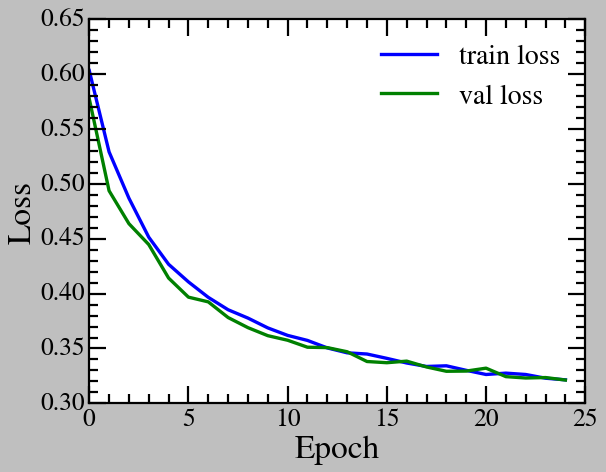

In [19]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

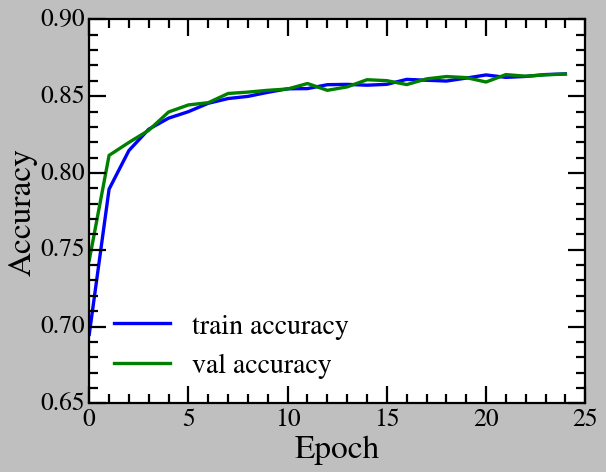

In [20]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [21]:
best_model_idx = np.argmin(training_stats['val_losses'])

print('Best detection rate:', training_stats['val_P_detections'][best_model_idx])
print('Best false alarm rate:', training_stats['val_P_false_alarms'][best_model_idx])

Best detection rate: 0.8882001671526167
Best false alarm rate: 0.15942753934197956


In [22]:
best_state_dict = torch.load('training_result/MLP_reduced_only_lepton/model/best.pth')['model_state_dict']
model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [23]:
nn_higgs_and_zz_data = four_leptons_nn.apply_nn_cut(
    all_higgs_and_zz_data, fields=fields, 
    model=model, batch_size=2048, num_workers=8,
    threshold=0.5, device='mps'
)

nn_higgs_data = nn_higgs_and_zz_data[:2]
nn_zz_data = nn_higgs_and_zz_data[2:8]
nn_dy_data = nn_higgs_and_zz_data[8:]

nn_data_data = four_leptons_nn.apply_nn_cut(
   data_all_data, fields=fields,
    model=model, batch_size=2048, num_workers=8,
    threshold=0.5, device='mps'
)


In [29]:
bins = np.linspace(50,200,61)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

nn_higgs_hist = four_leptons_data.get_histogram(nn_higgs_data, params.scales_higgs, 'm4l', bins) 
nn_zz_hist = four_leptons_data.get_histogram(nn_zz_data, params.scales_zz, 'm4l', bins)
nn_data_hist = four_leptons_data.get_histogram(nn_data_data, params.scales_data, 'm4l', bins)
nn_dy_hist = four_leptons_data.get_histogram(nn_dy_data, params.scales_dy, 'm4l', bins)

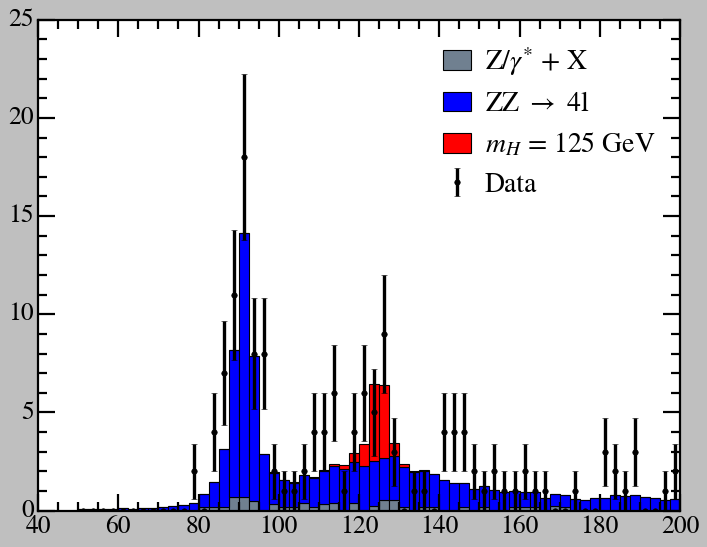

In [34]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, nn_dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='slategray')
stack = ax.bar(bin_centers, nn_zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue',bottom=nn_dy_hist)
stack = ax.bar(bin_centers, nn_higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red', bottom=nn_dy_hist+nn_zz_hist)
stack = ax.errorbar(bin_centers, nn_data_hist, yerr=np.sqrt(nn_data_hist), fmt='o', label='Data', color='black', markersize=5, capsize=3)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

Best fit mu-hat = 1.500
Significance = 4.24 sigma
p-value = 1.106604827383665e-05


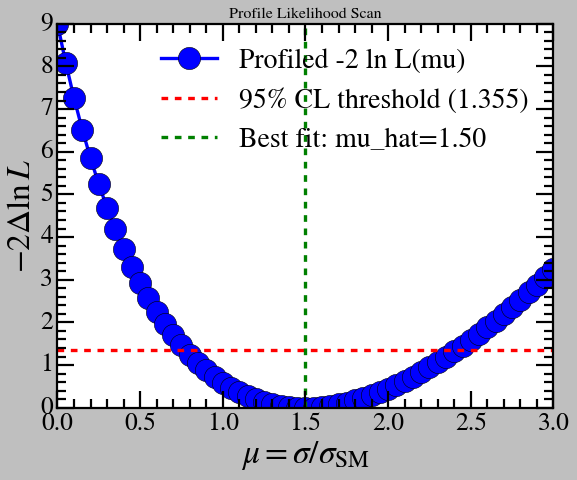

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

########################################
# 1) Construct total background vs. signal
########################################
# Suppose you've already computed the following histograms (like in your snippet):
#   hist       = data histogram (array of observed bin counts)
#   hist_higgs = MC Higgs signal histogram (scaled to 1x SM cross section)
#   hist_zz, hist_dy, hist_tt = background components
#
# Then let:
hist_background = nn_zz_hist
hist_signal = nn_higgs_hist
hist = nn_data_hist

# Make sure all arrays have the same shape
assert len(hist) == len(hist_background) == len(hist_signal), "Histogram length mismatch!"

########################################
# 2) Define a Poisson negative log-likelihood
########################################
def neg_log_likelihood(mu, hist_data, hist_sig, hist_bkg):
    """
    Returns the negative log-likelihood for a single set of (hist_data, hist_sig, hist_bkg)
    under the model: expected[i] = mu * hist_sig[i] + hist_bkg[i].
    
    Assumes Poisson in each bin i:
        L_i = e^-muS_i * (muS_i)^(n_i) / n_i!
    Summed over all bins => total NLL = - sum_i ln(L_i).
    
    - In practice, we skip constant n_i! (it doesn't affect minimization).
    - We also handle bins with zero expected yield carefully (avoid log(0)).
    """
    mu = max(mu, 0.0)  # enforce mu >= 0 for safety
    eps = 1e-12
    nll = 0.0
    for d, s, b in zip(hist_data, hist_sig, hist_bkg):
        expected = mu * s + b
        # Avoid log(0); impose a small floor
        expected = max(expected, eps)
        # Poisson -log L for bin
        # = expected - d * log(expected) + log(d!) [the last term is constant w.r.t mu]
        # We'll omit log(d!) because it's independent of mu
        nll_bin = expected - d * np.log(expected)
        nll += nll_bin
    return nll

########################################
# 3) Profile the likelihood over mu
########################################
def profile_likelihood(hist_data, hist_sig, hist_bkg, mu_values=None):
    """
    Evaluate negative log-likelihood for each mu in mu_values,
    returning arrays (mu_values, nll_values).
    """
    if mu_values is None:
        mu_values = np.linspace(0, 3.0, 61)  # from 0 to 3 in steps of 0.05, as an example
    nll_vals = []
    for mu in mu_values:
        val = neg_log_likelihood(mu, hist_data, hist_sig, hist_bkg)
        nll_vals.append(val)
    return np.array(mu_values), np.array(nll_vals)

# Let's do the likelihood scan
mu_grid = np.linspace(0, 3.0, 61)
mu_scan, nll_scan = profile_likelihood(hist, hist_signal, hist_background, mu_values=mu_grid)

# Find minimum (best-fit mu)
nll_min = np.min(nll_scan)
mu_hat = mu_scan[np.argmin(nll_scan)]
print(f"Best fit mu-hat = {mu_hat:.3f}")

########################################
# 4) Compute significance of signal (vs. background-only)
########################################
# A common measure: significance = sqrt( q_0 ), where
# q_0 = -2 ln[L(mu=0)/L(mu=mu_hat)]  (the test statistic for the background-only vs. best-fit).
#
# For background-only, mu=0:
nll_bkg = neg_log_likelihood(0.0, hist, hist_signal, hist_background)
q_0 = 2.0 * (nll_bkg - nll_min)
if q_0 < 0:
    q_0 = 0  # occasionally can happen due to statistical fluctuations
significance = np.sqrt(q_0)
print(f"Significance = {significance:.2f} sigma")
p_value = norm.sf(significance)  # survival function for one-sided test
print(f"p-value = {p_value}")

########################################
# 5) Estimate the 95% CL upper limit on mu (CLs style)
########################################
# For a simple 1D approach, a common approximation is:
# we find mu_up such that  -2 ln[ L(mu_up)/L(mu_hat) ] = 2.71  (for ~95% 1-sided).
# i.e.   NLL(mu_up) - NLL(mu_hat) = 1.355
########################################

delta_95 = 1.355  # 2.71 / 2 for the usual "q_mu" definition
# limit_95 = None

# for mu_test, nll_val in zip(mu_scan, nll_scan):
#     if (nll_val - nll_min) < delta_95:
#         # We crossed the threshold
#         limit_95 = mu_test
#         break

# if limit_95 is None:
#     limit_95 = mu_grid[-1]  # If we never crossed, the limit is above our scan range

# print(f"95% CL upper limit on mu = {limit_95:.2f}")

########################################
# 6) (Optionally) Visualize the likelihood scan
########################################
plt.figure()
plt.plot(mu_scan, nll_scan - nll_min, 'bo-', label="Profiled -2 ln L(mu)")
plt.axhline(delta_95, color='r', linestyle='--', label="95% CL threshold (1.355)")
plt.axvline(mu_hat, color='g', linestyle='--', label=f"Best fit: mu_hat={mu_hat:.2f}")
plt.xlabel(r"$\mu = \sigma / \sigma_{\mathrm{SM}}$")
plt.ylabel(r"$-2\Delta \ln L$")
plt.title("Profile Likelihood Scan")
plt.legend()
plt.show()
